In [2]:
import numpy as np
import pandas as pd
import cv2
import imutils
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from IPython.display import Image
import argparse
import os

In [3]:
import torch
from PIL import Image

CKPT_PATH = 'best.pt'
yolov5 = torch.hub.load('yolov5/',
                        'custom',
                        path=CKPT_PATH,
                        source='local',
                        force_reload=True)

'confidence: ' + str(yolov5.conf)

C:\Users\anarb\anaconda3\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
YOLOv5  2022-11-19 Python-3.9.13 torch-1.13.0 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


'confidence: 0.25'

In [4]:
import pytesseract
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image as Img
import imutils

In [5]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\anarb\AppData\Local\Tesseract-OCR\tesseract.exe'

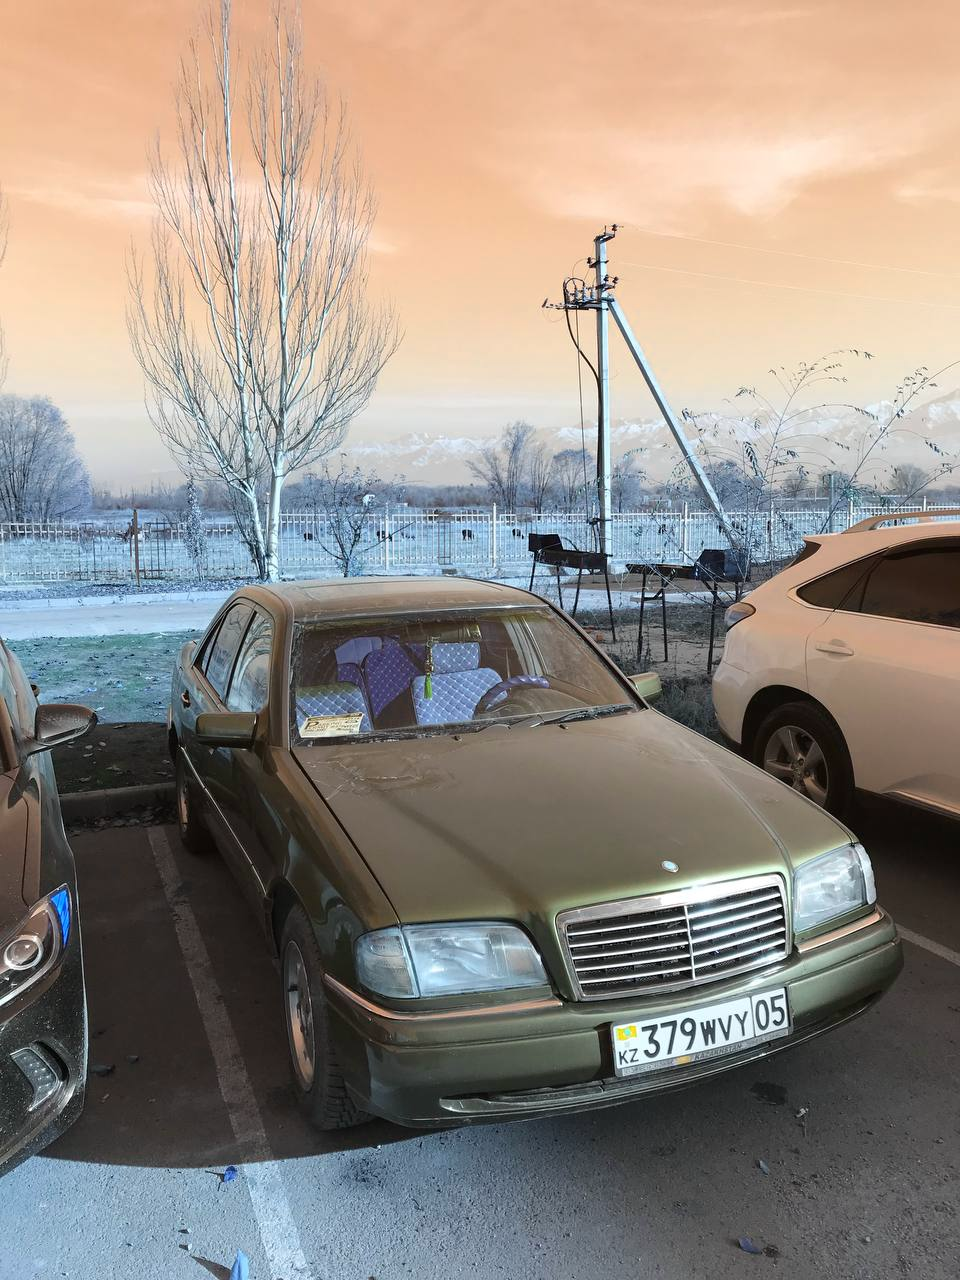

In [44]:
import cv2
img = cv2.imread('Cars/57.jpg')
width = 640
height = 640
dim = (width, height)
 
# resize image
 
pred = yolov5(img, size=640, augment=False)
display(Image.fromarray(img))

In [45]:
for i, row in pred.pandas().xyxy[0].iterrows():
    print(row['xmin'])

617.4781494140625


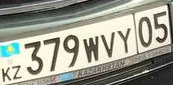

True

In [46]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
img_alpr = img[int(row['ymin']):int(row['ymax']),int(row['xmin']):int(row['xmax'])]    
display(Image.fromarray(img_alpr))
cv2.imwrite('t2.jpg', img_alpr)

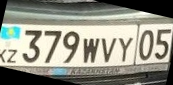

True

In [47]:
import numpy as np
import math
import cv2

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def compute_skew(src_img):
    
    if len(src_img.shape) == 3:
        h, w, _ = src_img.shape
    elif len(src_img.shape) == 2:
        h, w = src_img.shape
    else:
        print('upsupported image type')
        
    img = cv2.medianBlur(src_img, 3)
    
    edges = cv2.Canny(img,  threshold1 = 30,  threshold2 = 100, apertureSize = 3, L2gradient = True)
    lines = cv2.HoughLinesP(edges, 1, math.pi/180, 30, minLineLength=w / 4.0, maxLineGap=h/4.0)
    angle = 0.0
    nlines = lines.size
    
    #print(nlines)
    cnt = 0
    for x1, y1, x2, y2 in lines[0]:
        ang = np.arctan2(y2 - y1, x2 - x1)
        #print(ang)
        if math.fabs(ang) <= 30: # excluding extreme rotations
            angle += ang
            cnt += 1
    
    if cnt == 0:
        return 0.0
    return (angle / cnt)*180/math.pi

def deskew(src_img):
    return rotate_image(src_img, compute_skew(src_img))
  

img = cv2.imread('t2.jpg')
corrected_img = deskew(img)
display(Image.fromarray(corrected_img))
cv2.imwrite('t3.jpg', corrected_img)


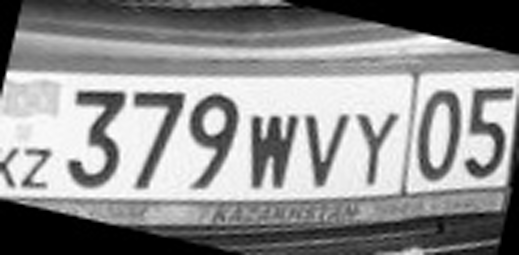

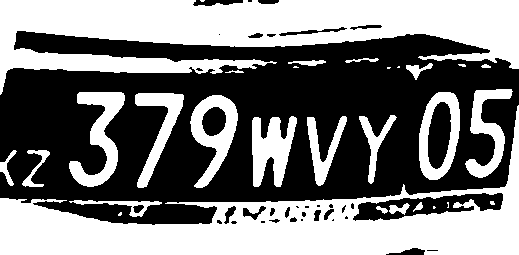

379WVY05


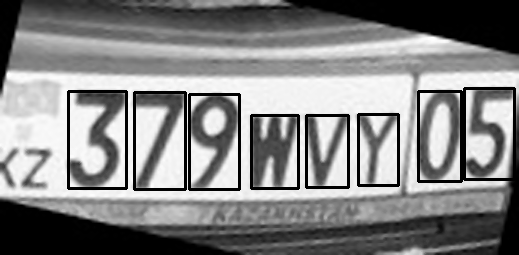

In [48]:
from PIL import Image
import pytesseract
gray = cv2.imread('t3.jpg', cv2.IMREAD_GRAYSCALE)
gray = cv2.resize( gray, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
blur = cv2.GaussianBlur(gray, (5,5), 0)
display(Image.fromarray(gray))
gray = cv2.medianBlur(gray, 3)
# perform otsu thresh (using binary inverse since opencv contours work better with white text)
#the algorithm returns a single intensity threshold that separate pixels into two classes
ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
display(Image.fromarray(thresh))

rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

# apply dilation 
#Dilation adds pixels to the boundaries of objects in an image
dilation = cv2.dilate(thresh, rect_kern, iterations = 1)
#cv2.imshow("dilation", dilation)
#cv2.waitKey(0)
# find contours
try:
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
except:
    ret_img, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

# create copy of image
im2 = gray.copy()

plate_num = ""
# loop through contours and find letters in license plate
for cnt in sorted_contours:
    x,y,w,h = cv2.boundingRect(cnt)
    height, width = im2.shape
    
    # if height of box is not a quarter of total height then skip
    if height / float(h) > 6: continue
    ratio = h / float(w)
    # if height to width ratio is less than 1.5 skip
    if ratio < 1.2: continue
    area = h * w
    # if width is not more than 25 pixels skip
    if width / float(w) > 18: continue
    # if area is less than 100 pixels skip
    if area < 100: continue
    # draw the rectangle
    rect = cv2.rectangle(im2, (x,y), (x+w, y+h), (0,255,0),2)
    roi = thresh[y-5:y+h+5, x-5:x+w+5]
    roi = cv2.bitwise_not(roi)
    roi = cv2.medianBlur(roi, 5)
    #cv2.imshow("ROI", roi)
    #cv2.waitKey(0)
    text = pytesseract.image_to_string(roi, config='-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 8 --oem 3')
    #print(text)
    text = text.strip()
    plate_num += text
print(plate_num)
display(Image.fromarray(im2))

